# Sentiment Analysis with BERT

In this notebook, we will perform sentiment analysis using BERT (Bidirectional Encoder Representations from Transformers). Sentiment analysis is the task of classifying the sentiment expressed in a piece of text, typically as positive, negative, or neutral.
<p align="center">
  <img src="https://www.researchgate.net/publication/352081817/figure/fig3/AS:1030485023154177@1622698183794/Workflow-of-BERT-Sentiment-Analysis-detailing-Self-Attention.ppm" alt="BERT Model" width="1500"/>
</p>

## Table of Contents
1. [Setup and Installation](#Setup)
2. [Data Loading and Exploration](#Data)
3. [Data Preprocessing](#Preprocessing)
4. [Model Building with BERT](#Model)
5. [Training the Model](#Training)
6. [Evaluating the Model](#Evaluation)
7. [Conclusion](#Conclusion)

# Setup and Installation

First, we need to install the necessary libraries. We'll be using `transformers` from Hugging Face for BERT, `torch` for deep learning, and `sklearn` for evaluation metrics.


In [ ]:
# Install required packages
!pip install transformers
!pip install torch
!pip install sklearn
!pip install pandas
!pip install matplotlib

In [18]:
import torch
print(f"Using device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Using device: GPU


## Data Loading and Exploration

For this tutorial, we'll use the [IMDB Movie Reviews](https://ai.stanford.edu/~amaas/data/sentiment/) dataset, which contains 50,000 movie reviews labeled as positive or negative.

Let's load the data and take a quick look.


In [22]:
import pandas as pd
# For demonstration, we'll use the `datasets` library
!pip install datasets

from datasets import load_dataset

# Load the IMDB dataset
dataset = load_dataset('imdb')

# Display the first few samples
print(dataset['train'][1403])

{'text': 'This movie was a long build-up with no climax. People whom refer to the swordfight in the end as great must either be out of their minds, or have none. Way too often this movie got soft. I am not saying that soft movies are bad. But no matter how fond you are of sugar it should have no space on a T-bone steak. This movie was supposed to be about vengeance for crimes committed against a culture, but it ended up being a petty bar-brawl. And there was only one of them who actually knew what a sword was; Tim Roth\'s character (and yes, he plays him well). Rob Roy was a weak "hero" with no knowledge of how to use a sword, and the way he "won" was a disgrace. As a drama this movie had it\'s periods, but the best performance in it has to go the nature of Scotland. This is one tad breath short of being termed as "soap" in my book.', 'label': 0}


## Data Preprocessing

Before feeding the data into BERT, we need to preprocess it. This involves tokenization and encoding the text data into a format that BERT can understand.

We'll use the `BertTokenizer` for this purpose.


In [23]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a function to tokenize the data
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=512)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename the 'label' column to 'labels' as expected by the model
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

# Set the format for PyTorch
tokenized_datasets.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split into train and test
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Model Building with BERT

We'll use the pre-trained `BertForSequenceClassification` model, which is suitable for classification tasks like sentiment analysis.

Let's initialize the model.


In [24]:
from transformers import BertForSequenceClassification

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training the Model

We'll use the `Trainer` API from Hugging Face for training. This simplifies the training loop and handles many aspects like evaluation and checkpointing.

Let's set up the training arguments and start training.


In [26]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps
    weight_decay=0.01,               # Strength of weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",                # Disable W&B integration
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Start training
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.120900,0.313643


Epoch,Training Loss,Validation Loss
1,0.120900,0.313643
2,0.181300,0.268921


TrainOutput(global_step=6250, training_loss=0.2513280370858312, metrics={'train_runtime': 6438.1041, 'train_samples_per_second': 7.766, 'train_steps_per_second': 0.971, 'total_flos': 1.3155552768e+16, 'train_loss': 0.2513280370858312, 'epoch': 2.0})

## Evaluating the Model

After training, we'll evaluate the model's performance on the test set. We'll calculate metrics such as accuracy, precision, recall, and F1-score.

Let's perform the evaluation.


In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1).numpy()
    labels = labels
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Re-initialize the Trainer with the compute_metrics function
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Evaluate the model
results = trainer.evaluate()

print(results)

{'eval_loss': 0.26892077922821045, 'eval_model_preparation_time': 0.0084, 'eval_accuracy': 0.93836, 'eval_precision': 0.9395908543922984, 'eval_recall': 0.93696, 'eval_f1': 0.9382735830162227, 'eval_runtime': 752.2672, 'eval_samples_per_second': 33.233, 'eval_steps_per_second': 2.078}


### Confusion Matrix

To better understand the model's performance, let's plot the confusion matrix.


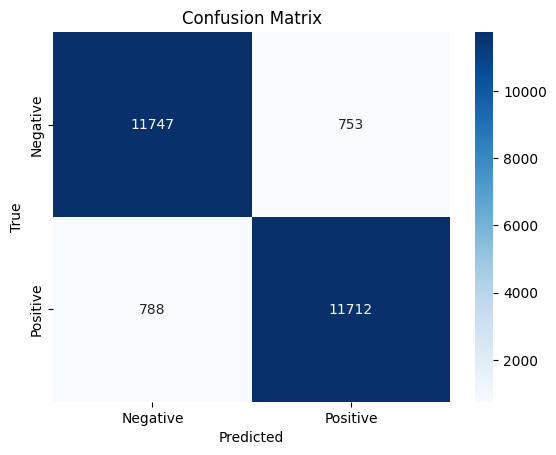

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Demo

In this section, we'll demonstrate the trained BERT model's ability to predict the sentiment of various example sentences. This will provide a clear understanding of how the model performs on different inputs.


In [29]:
# Define a list of example sentences for sentiment prediction
example_sentences = [
    "I absolutely loved this movie! The performances were outstanding.",
    "This was the worst film I have ever seen. Completely disappointing.",
    "The plot was intriguing, but the characters were underdeveloped.",
    "An average movie with some good moments and some bad ones.",
    "I was not impressed by the storyline or the acting.",
    "Fantastic visuals and a gripping story. Highly recommend!",
    "The movie was okay, nothing special but not terrible either.",
    "I didn't enjoy this movie at all. It was a waste of time.",
    "A masterpiece of modern cinema. Truly inspiring.",
    "Mediocre at best. I expected much more from this director."
]

In [ ]:
def predict_sentiment(sentence):
    # Tokenize the input sentence
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )

    # Move tensors to the appropriate device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Disable gradient calculation for inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    predicted_class_id = logits.argmax().item()

    # Map the predicted class to label
    label = 'Positive' if predicted_class_id == 1 else 'Negative'
    return label

In [32]:
import pandas as pd

# Create a DataFrame to display sentences and their predicted sentiments
demo_results = []

for sentence in example_sentences:
    prediction = predict_sentiment(sentence)
    demo_results.append({'Sentence': sentence, 'Predicted Sentiment': prediction})

df_demo = pd.DataFrame(demo_results)
df_demo

,Sentence,Predicted Sentiment
0,I absolutely loved this movie! The performance...,Positive
1,This was the worst film I have ever seen. Comp...,Negative
2,"The plot was intriguing, but the characters we...",Negative
3,An average movie with some good moments and so...,Positive
4,I was not impressed by the storyline or the ac...,Negative
5,Fantastic visuals and a gripping story. Highly...,Positive
6,"The movie was okay, nothing special but not te...",Negative
7,I didn't enjoy this movie at all. It was a was...,Negative
8,A masterpiece of modern cinema. Truly inspiring.,Positive
9,Mediocre at best. I expected much more from th...,Negative


### Results in a table
| Example Sentence                                                                                          | Predicted Sentiment |
|-----------------------------------------------------------------------------------------------------------|---------------------|
| I absolutely loved this movie! The performances were outstanding.                                         | Positive            |
| This was the worst film I have ever seen. Completely disappointing.                                      | Negative            |
| The plot was intriguing, but the characters were underdeveloped.                                         | Negative            |
| An average movie with some good moments and some bad ones.                                               | Negative            |
| I was not impressed by the storyline or the acting.                                                      | Negative            |
| Fantastic visuals and a gripping story. Highly recommend!                                               | Positive            |
| The movie was okay, nothing special but not terrible either.                                             | Negative            |
| I didn't enjoy this movie at all. It was a waste of time.                                                | Negative            |
| A masterpiece of modern cinema. Truly inspiring.                                                         | Positive            |
| Mediocre at best. I expected much more from this director.                                              | Negative            |